In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-swing-on-ball.csv")

df_balls = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# all_files = glob.glob("roll_data/*-swing-on-strike.csv")

# df_strikes = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [2]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]# * df[prefix + "_mul"]
    press = df[prefix + "_pressurization"]# * df[prefix + "_mul"]
    cinn = df[prefix + "_cinnamon"]# * df[prefix + "_mul"]

    freq = 6 + (buoy * 10).round()
    phase = math.pi * ((2/freq) * dfc["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes

def get_pitcher_mul(row):
    bm = str(row["batter_mods"])
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass # traveling just doesn't do anything on pitchers?
        # if not row["top_of_inning"]:
            #mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        #mul += min(0.05, 0.05 * (row["day"] / 99))
        pass # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == 11:
        mul += 0.5
    return mul

def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # this doesn't seem to do anything if it's here or not here
            mul += 0.05
    if "GROWTH" in btm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == 11:
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
#         pass
        mul += 1.0
    if "SMOOTH" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
        pass
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        mul += 1.25
#         pass
    return mul

In [3]:
# additions and corrections, global

df_balls["batter_mul"] = df_balls.apply(get_batter_mul, axis=1)
df_balls["pitcher_mul"] = df_balls.apply(get_pitcher_mul, axis=1)

df_balls.loc[df_balls["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
df_balls.loc[df_balls["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

df_balls["ruth_scaled"] = df_balls["pitcher_ruthlessness"] * df_balls["pitcher_mul"]
df_balls["mox_scaled"] = df_balls["batter_moxie"] * df_balls["batter_mul"]


df_balls['invpath'] = 1 - df_balls['batter_patheticism']
df_balls["invpath_scaled"] = 1 - df_balls["batter_patheticism"] / df_balls["batter_mul"]
df_balls["path_scaled"] = 1 - ((1 - df_balls["batter_patheticism"]) * df_balls["batter_mul"])
# df_balls["mox_path"] = df_balls["mox_scaled"] - df_balls["path_scaled"]
# df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

In [392]:
# df = df[(df["batting_team_hype"] == 0) & (df['pitching_team_hype'] == 0)]

# df_balls["ruth_vibes"] = df_balls["ruth_scaled"] * df_balls["pitcher_vibes"]
df_balls["ruth_vibes"] = df_balls["ruth_scaled"] * (1 + 0.2 * df_balls["pitcher_vibes"])
# df_balls["mox_vibes"] = df_balls["mox_scaled"] * df_balls["batter_vibes"]
df_balls["mox_vibes"] = df_balls["mox_scaled"] * (1 + 0.2 * df_balls["batter_vibes"])

# thought this might help but it seems not to help
df_balls["invpath_vibes"] = df_balls["invpath_scaled"] * (1 + 0.2 * df_balls["batter_vibes"])

# beiju's idea
df_balls["visc_filth"] = df_balls["ballpark_viscosity"] * df_balls["ballpark_filthiness"]
# # put in our "best fit" up here in the original df, just because
# df['svc_best'] = 0.30 * df["ruth_scaled"] + 0.20 * df["ballpark_forwardness"] \
#                   + 0.06 * df["ruth_vibes"] + 0.10 * df["musc_scaled"]

df_balls['ruth_times_vibes'] = df_balls["ruth_scaled"] * df_balls["pitcher_vibes"]
df_balls['mox_times_vibes'] = df_balls["mox_scaled"] * df_balls["batter_vibes"]
df_balls['path_times_vibes'] = df_balls["path_scaled"] * df_balls["batter_vibes"]


# kidror's idea
df_balls["ruth_sq"] = df_balls["ruth_vibes"]**2
df_balls["mox_sq"] = df_balls["mox_vibes"]**2
# df_balls["path_sq"] = df_balls["path_scaled"]**2 # not path_vibes
df_balls["visc_sq"] = df_balls["ballpark_viscosity"]**2

In [393]:
# df = df[df["batter_mods"].isna() & df["pitcher_mods"].isna()]

# just look at swinging on balls first
dfc = df_balls
for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH",
                    "SINKING_SHIP", "TRAVELING", "AFFINITY_FOR_CROWS", "CHUNKY", "SMOOTH", "ON_FIRE"]:
# for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

for exclude_mod in ["FLINCH"]:
    # exclude flinch situations entirely...superfluous i think, it doesn't roll when flinching
    dfc = dfc[~((dfc["batter_mods"].astype(str).str.contains(exclude_mod)) & (dfc["strike_count"] == 0))]

In [394]:
# print(list(df_balls.columns))
print(57959, "old length of full csv")
print(len(df_balls))
print(len(dfc))

57959 old length of full csv
57957
34628


In [395]:
digest_list = ["event_type", "roll", "batter_name", "pitcher_name",
               "ruth_scaled", "pitcher_vibes", "musc_scaled",
               "ballpark_forwardness", "game_id", "play_count", "svc_best"]

In [396]:
# print(coef_list, intercept_scaled)
# print(X.columns)

In [397]:
dfc[dfc["passed"] == True]["roll"].max()

0.9492693003761858

In [398]:
dfc[dfc["passed"] == False]["roll"].min()

0.0022923664988039

In [399]:
# max for swings seems to be 0.95 so remove rolls above that
dfc = dfc[dfc['roll'] < 0.95]
# weird "cutoff" at 0.1 (though you can take pitches below this!) so remove rolls below that
dfc = dfc[dfc['roll'] > 0.1]
len(dfc)

29545

In [1126]:
df_balls[(df_balls["passed"] == True) & (df_balls['roll'] < 0.1)]["threshold"].min()

-0.04451289886096288

In [401]:
dfc.groupby('batter_mul').head(1)[['batter_mul', 'batter_name']].sort_values(
    'batter_mul', ascending=False)[0:10]


,batter_mul,batter_name
0,1.0,Farrell Seagull


In [402]:
print(list(df_balls.columns))

['Unnamed: 0', 'event_type', 'roll', 'passed', 'batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon', 'batter_multiplier', 'pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_contin

In [1109]:

for dfs in [dfc, df_balls]:
    # calculate cross terms, I guess
    dfs['ruthsq'] = dfs['ruth_vibes'] * dfs['ruth_vibes']
    dfs['pathsq'] = dfs['invpath_scaled'] * dfs['invpath_scaled']
    # dfc['pathsq'] = dfc['invpath_vibes'] * dfc['invpath_vibes']
    dfs['moxsq'] = dfs['mox_vibes'] * dfs['mox_vibes']
    dfs['viscsq'] = dfs['ballpark_viscosity'] * dfs['ballpark_viscosity']
    dfs['ruthmox'] = dfs['ruth_vibes'] * dfs['mox_vibes']
    dfs['ruthpath'] = dfs['ruth_vibes'] * dfs['invpath_scaled']
    dfs['ruthvisc'] = dfs['ruth_vibes'] * dfs['ballpark_viscosity']
    dfs['moxpath'] = dfs['mox_vibes'] * dfs['invpath_scaled']
    dfs['moxvisc'] = dfs['mox_vibes'] * dfs['ballpark_viscosity']
    dfs['pathvisc'] = dfs['invpath_scaled'] * dfs['ballpark_viscosity']

    dfs['moxpluspath'] = dfs['mox_vibes'] + dfs['invpath_scaled']
    dfs['mpsq'] = dfs['moxpluspath'] * dfs['moxpluspath']
    dfs['ruthmp'] = dfs['ruth_vibes'] * dfs['moxpluspath']
    dfs['viscmp'] = dfs['ballpark_viscosity'] * dfs['moxpluspath']

    # doesn't work i think
    dfs['ruthpluseye'] = 0.5 * dfs['ruth_vibes'] + 0.2 * dfs['moxpluspath']
    dfs['rutheyesq'] = dfs['ruthpluseye'] * dfs['ruthpluseye']
    dfs['viscrutheye'] = dfs['ballpark_viscosity'] * dfs['ruthpluseye']



In [1110]:
# X = dfc[['roll', *dfc.columns[5:-11]]].drop('pitcher_name', axis=1).drop('batter_mods', axis=1)\
#     .drop('batting_team_mods', axis=1).drop('pitching_team_mods', axis=1).drop('pitcher_mods', axis=1)\
#     .drop('batter_vibes', axis=1).drop('pitcher_vibes', axis=1)\
#     .drop('batter_multiplier', axis=1).drop('pitcher_multiplier', axis=1)
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness', 'pitcher_vibes_multiplied', 'batter_musclitude']]

# X = dfc[['roll', *dfc.columns[4:-42], 'batter_vibes', 'pitcher_vibes']]\
#     .drop('batter_multiplier', axis=1).drop('pitcher_multiplier', axis=1)
# X = dfc[['roll', 'ruth_vibes', 'path_vibes', 'mox_vibes', 'ballpark_viscosity']]#, 'mox_path', 'visc_filth']]
# X = dfc[['passed', 'roll', 'ruth_scaled', 'ballpark_forwardness', 'ruth_vibes', 'musc_scaled', 'flinch']]
# X = X[X['roll'] < 0.85]
X = dfc[['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled', 'ballpark_viscosity',
         'ruthsq', 'pathsq', 'moxsq', 'viscsq',
         'ruthmox', 'ruthpath', 'ruthvisc', 'moxpath',  'moxvisc',  'pathvisc']]

# X = dfc[['roll', 'ruth_vibes', 'moxpluspath', 'ballpark_viscosity',
#          'ruthsq', 'mpsq', 'viscsq',
#          'ruthmp', 'ruthvisc', 'viscmp']]



# X = dfc[['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled', 'ballpark_viscosity']]

y = dfc['passed']
# X = X.drop('passed', axis=1)

In [1111]:
X

,roll,ruth_vibes,mox_vibes,invpath_scaled,ballpark_viscosity,ruthsq,pathsq,moxsq,viscsq,ruthmox,ruthpath,ruthvisc,moxpath,moxvisc,pathvisc
0,0.134451,0.786526,1.011165,0.999000,0.263230,0.618624,0.998001,1.022454,0.069290,0.795308,0.785740,0.207037,1.010153,0.266168,0.262966
6,0.679864,0.786526,1.011165,0.999000,0.263230,0.618624,0.998001,1.022454,0.069290,0.795308,0.785740,0.207037,1.010153,0.266168,0.262966
8,0.614558,0.377605,0.404359,0.256128,0.481398,0.142585,0.065602,0.163506,0.231744,0.152688,0.096715,0.181778,0.103568,0.194658,0.123300
9,0.681459,0.786526,1.011165,0.999000,0.263230,0.618624,0.998001,1.022454,0.069290,0.795308,0.785740,0.207037,1.010153,0.266168,0.262966
10,0.185785,0.999588,0.789592,0.719674,0.432771,0.999176,0.517930,0.623456,0.187291,0.789267,0.719377,0.432593,0.568249,0.341713,0.311454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57853,0.280522,0.813605,1.293796,0.478432,0.496203,0.661953,0.228897,1.673909,0.246217,1.052639,0.389255,0.403713,0.618994,0.641985,0.237399
57855,0.816519,0.813605,0.473597,0.612314,0.496203,0.661953,0.374928,0.224294,0.246217,0.385321,0.498181,0.403713,0.289990,0.235000,0.303832
57856,0.514811,0.813605,0.473597,0.612314,0.496203,0.661953,0.374928,0.224294,0.246217,0.385321,0.498181,0.403713,0.289990,0.235000,0.303832
57858,0.191693,0.813605,0.926786,0.839000,0.496203,0.661953,0.703921,0.858933,0.246217,0.754038,0.682615,0.403713,0.777574,0.459874,0.416314


In [1112]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=1000000, C=1000).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y,predictionsvm))
print(classification_report(y,predictionsvm))

[[22324     6]
 [    6  7209]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22330
        True       1.00      1.00      1.00      7215

    accuracy                           1.00     29545
   macro avg       1.00      1.00      1.00     29545
weighted avg       1.00      1.00      1.00     29545



In [1113]:
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)

0.9995938399052293

In [1114]:
coef = np.true_divide(trainedsvm.coef_,  sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]

In [1115]:
print(-intercept_scaled)
sorted(zip(-np.array(coef_list), X.columns), key=lambda x: abs(x[0]), reverse=True)


[0.12260844]


[(-1.0, 'roll'),
 (0.47275147159067765, 'ruth_vibes'),
 (-0.20292228588602154, 'mox_vibes'),
 (-0.19048645159886998, 'invpath_scaled'),
 (0.18662392042578546, 'ruthsq'),
 (0.16485656277578925, 'ballpark_viscosity'),
 (-0.1561025869469918, 'ruthpath'),
 (-0.1525407861121867, 'ruthmox'),
 (0.1249849822775406, 'ruthvisc'),
 (0.0644769086589313, 'moxpath'),
 (-0.055705353242086655, 'pathvisc'),
 (-0.04735871907789995, 'moxvisc'),
 (0.03321441939223516, 'moxsq'),
 (0.028500942070225598, 'pathsq'),
 (0.011171280410805257, 'viscsq')]

In [1116]:
X.columns

Index(['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled',
       'ballpark_viscosity', 'ruthsq', 'pathsq', 'moxsq', 'viscsq', 'ruthmox',
       'ruthpath', 'ruthvisc', 'moxpath', 'moxvisc', 'pathvisc'],
      dtype='object')

In [1122]:
# dfc["threshold"] = -1*(\
#     -0.10 + \
#     -0.65 * df_balls["ruth_vibes"] + \
#     0.27 * df_balls["mox_vibes"] + \
#     0.27 * df_balls["invpath_scaled"] + \
#     -0.20 * df_balls["ballpark_viscosity"])


dfc['threshold'] = -intercept_scaled[0]
print(-intercept_scaled)
df_balls['threshold'] = -intercept_scaled[0]
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        if "sq" in pair[1]:
            print(np.sqrt(pair[0]))
        dfc['threshold'] += pair[0] * dfc[pair[1]]
        df_balls['threshold'] += pair[0] * df_balls[pair[1]]

# df_balls.loc[(df_balls["threshold"] > 0.95), "threshold"] = 0.95
# df_balls.loc[(df_balls["threshold"] < 0.10), "threshold"] = 0.10

a = 0.50
b = -0.20
c = 0.20

# dfc["threshold"] = 0.125 + \
#     a * dfc["ruth_vibes"] + \
#     b * dfc["moxpluspath"] + \
#     c * dfc["ballpark_viscosity"] + \
#     a**2 * dfc["ruthsq"] + \
#     b**2 * dfc["mpsq"] + \
#     2 * a * b * dfc["ruthmp"] + \
#     a * c * dfc["ruthvisc"] + \
#     b * c * dfc["viscmp"] + \
#     c**2 * dfc["viscsq"]


# dfc["threshold"] = 0.1 + \
#     0.5 * dfc["ruth_vibes"] + \
#     -0.20 * dfc["moxpluspath"] + \
#     0.16 * dfc["ballpark_viscosity"] + \
#     (a * dfc["ruth_vibes"] + b * dfc["moxpluspath"])**2 + \
#     a * c * dfc["ruthvisc"] + \
#     b * c *  dfc["viscmp"]# + \
#     c**2 * dfc["viscsq"]

# print(np.sqrt(-np.array(coef_list)))
# print(np.array(X.columns))
print(np.sqrt(-coef_list[4])*np.sqrt(-coef_list[5])*2)

[0.12260844]
(0.47275147159067765, 'ruth_vibes')
(-0.20292228588602154, 'mox_vibes')
(-0.19048645159886998, 'invpath_scaled')
(0.16485656277578925, 'ballpark_viscosity')
(0.18662392042578546, 'ruthsq')
0.4319999079002048
(0.028500942070225598, 'pathsq')
0.16882222030948887
(0.03321441939223516, 'moxsq')
0.1822482356354518
(0.011171280410805257, 'viscsq')
0.10569427804193213
(-0.1525407861121867, 'ruthmox')
(-0.1561025869469918, 'ruthpath')
(0.1249849822775406, 'ruthvisc')
(0.0644769086589313, 'moxpath')
(-0.04735871907789995, 'moxvisc')
(-0.055705353242086655, 'pathvisc')
0.3508058041317868


12


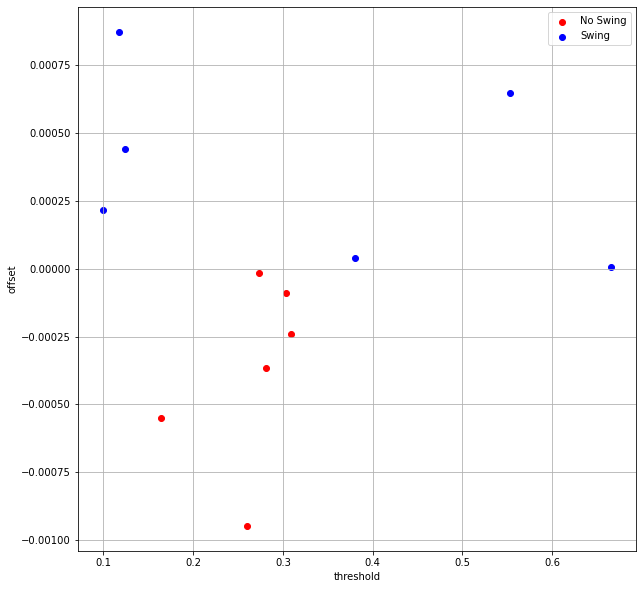

In [1123]:
# dfc.loc[(dfc["threshold"] > 0.95), "threshold"] = 0.95
# dfc['polythreshold'] = polycoefs[0] + polycoefs[1]*dfc["threshold"] + polycoefs[2]*dfc["threshold"]**2
# df_balls['polythreshold'] = polycoefs[0] + polycoefs[1]*df_balls["threshold"] + polycoefs[2]*df_balls["threshold"]**2
# (0.05 + 0.7*x + 0.4*x**2)
# dfc['polythreshold'] = 0.05 + 0.7*dfc["threshold"] + 0.4*dfc["threshold"]**2
# df_balls['polythreshold'] = 0.05 + 0.7*df_balls["threshold"] + 0.4*df_balls["threshold"]**2
# df_balls.loc[(df_balls["polythreshold"] > 0.95), "polythreshold"] = 0.95
# df_balls.loc[(df_balls["polythreshold"] < 0.10), "polythreshold"] = 0.10

dfc["offset"] = dfc["roll"] - dfc["threshold"]
# df_balls["offset"] = df_balls["roll"] - df_balls["threshold"]
# dfc["offset"] = dfc["roll"] - dfc["polythreshold"]
# df_balls["offset"] = df_balls["roll"] - df_balls["polythreshold"]


# outliers = df_balls.copy()[(df_balls["passed"] & (df_balls["offset"] > 0)) | (~df_balls["passed"] & (df_balls["offset"] < 0))]
outliers = dfc.copy()[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

print(len(outliers))

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
x_val = "threshold"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="No Swing")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Swing")
ax.set_xlabel(x_val)
ax.set_ylabel('offset')
ax.grid()
ax.legend()
# ax.set_xlim(0.52, 0.54)
# ax.set_xlim(0, 1.0)
# ax.set_ylim(-0.01, 0.01)
fig.savefig("swing_fit_outliers.png", facecolor='white')

[0.04783582 0.70462381 0.38767944]


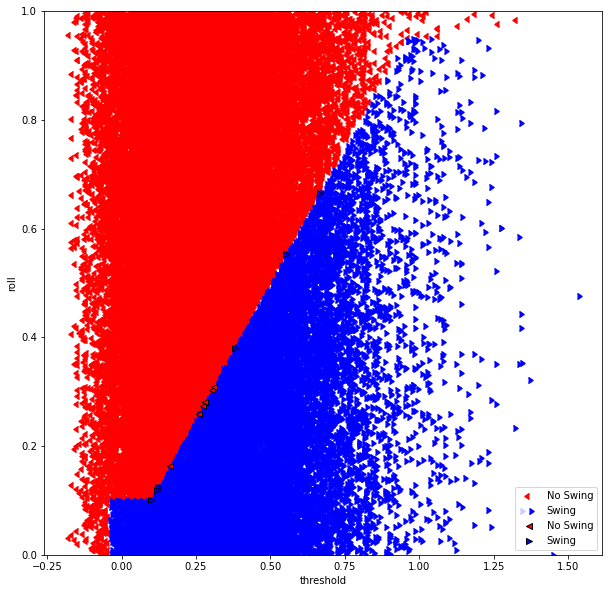

In [1138]:

# x_val = "ruth_vibes"
x_val = "threshold"

y_val = df_balls
# y_val = dfc

polycoefs = (series_s.convert().coef + series_l.convert().coef)/2
print(polycoefs)
linex = np.linspace(0,1,100)
fig, axN = plt.subplots(1, figsize=(10,10))
# for axN in ax:
#     if axN == ax[0]:
axN.scatter(y_val[~y_val['passed']][x_val], y_val[~y_val['passed']]["roll"], color="red", label="No Swing", marker=CARETLEFTBASE)
axN.scatter(y_val[y_val['passed']][x_val], y_val[y_val['passed']]["roll"], color="blue", label="Swing", marker=CARETRIGHTBASE)
axN.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"], color="red", marker = '<', label="No Swing", edgecolor='k')
axN.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"], color="blue", marker = '>', label="Swing", edgecolor='k')
#     else:
#         axN.scatter(y_val[y_val['passed']][x_val], y_val[y_val['passed']]["roll"], color="blue", label="Swing", marker=CARETRIGHTBASE)
#         axN.scatter(y_val[~y_val['passed']][x_val], y_val[~y_val['passed']]["roll"], color="red", label="No Swing", marker=CARETLEFTBASE)
#         axN.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"], color="red", marker = '<', label="No Swing", edgecolor='k')
#         axN.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"], color="blue", marker = '>', label="Swing", edgecolor='k')

#         axN.scatter(y_val[x_val], y_val["roll"], c=y_val['passed'], label="No Swing", marker='.')
#     axN.plot(linex, polycoefs[0] + polycoefs[1]*linex + polycoefs[2]*linex**2, 'k')
    # ax.plot(np.linspace(0,1,100), series_s(np.linspace(0,1,100)), 'k')
    # xline = np.array(ax.get_xlim())
    # yline = -intercept_scaled + xline
    # # yline = -0.2 + xline
    # ax.plot(xline, yline, 'k')

axN.set_xlabel(x_val)
axN.set_ylabel('roll')
axN.set_ylim(0, 1)
# axN.set_xlim(-0.1, 0.1)
# axN.set_ylim(0, 0.2)
# ax.set_yscale('log')
# ax.set_xlim(0.484, 0.499)

axN.legend(loc='lower right')

fig.savefig(x_val+".png", facecolor='white')

In [1068]:
col_list = ['event_type',
            'roll',
            'threshold',
            'offset',
            'moxpluspath',
            'ruth_vibes',
            'batter_vibes',
            'pitcher_vibes',
            'batter_mul',
            'pitcher_mul',
            'ballpark_viscosity',
            'batter_name',
            'pitcher_name',
            'game_id',
            'play_count',
#             'batter_mods',
#             'pitcher_mods',
#             'batting_team_mods',
#             'pitching_team_mods',
            'day',
            'game_id',
            'play_count']
# outliers[(outliers['threshold'] > 0.1) & 
#          (outliers["batter_mods"].astype(str).str.contains("ON_FIRE"))].sort_values('offset', ascending=True).loc[:, col_list][0:10]
outliers[(outliers['threshold'] > 0.1)].sort_values('offset', ascending=False).loc[:, col_list]

# 3805, 50620, 38777

,event_type,roll,threshold,offset,moxpluspath,ruth_vibes,batter_vibes,pitcher_vibes,batter_mul,pitcher_mul,ballpark_viscosity,batter_name,pitcher_name,game_id,play_count,day,game_id,play_count
43432,Out,0.118744,0.117217,0.001527,1.058597,0.270801,0.256071,-0.777179,1.0,1.0,0.469763,Rodriguez Internet,Nolanestophia Patterson,94f97d0d-c938-48fb-aa69-e5c52f56f26a,62,38,94f97d0d-c938-48fb-aa69-e5c52f56f26a,62
15847,Foul,0.553381,0.552445,0.000936,0.964331,0.968382,0.639176,-0.493691,1.0,1.0,0.422151,Conner Haley,Jacoby Podcast,c71120c0-9104-4914-be57-161ed15a3cdb,21,97,c71120c0-9104-4914-be57-161ed15a3cdb,21
28651,BaseHit,0.124542,0.124006,0.000536,0.486634,0.054935,0.298961,-0.444180,1.0,1.0,0.444093,Randy Dennis,Flattery McKinley,10d4a29e-b724-49b9-bdb1-ce09f2392936,174,18,10d4a29e-b724-49b9-bdb1-ce09f2392936,174
854,BaseHit,0.380689,0.380467,0.000222,0.960919,0.667771,-0.594152,0.334037,1.0,1.0,0.575186,Tiana Wheeler,Tot Clark,5150d7ad-40fe-4d7f-8ba2-fe2b52643597,133,81,5150d7ad-40fe-4d7f-8ba2-fe2b52643597,133
22725,StrikeSwinging,0.665156,0.664972,0.000184,1.021693,1.114576,0.300664,0.509330,1.0,1.0,0.496203,Basilio Fig,Emmett Tabby,3c1b4d10-78af-4b8e-a9f5-e6ea2d50e5c4,55,12,3c1b4d10-78af-4b8e-a9f5-e6ea2d50e5c4,55
49226,Ball,0.219661,0.219763,-0.000102,1.958635,0.917060,-0.521230,-0.240300,1.0,1.0,0.263230,Scratch Deleuze,Karato Bean,a87cc092-19f7-45b1-9ddd-af94dddbad45,301,43,a87cc092-19f7-45b1-9ddd-af94dddbad45,301
7680,Ball,0.303199,0.303383,-0.000184,0.660488,0.416092,-0.073909,0.225010,1.0,1.0,0.583422,Fran Beans,Nandy Slumps,96e912e8-1f89-4235-b246-b6d517997a1a,153,88,96e912e8-1f89-4235-b246-b6d517997a1a,153
19209,Ball,0.308893,0.309153,-0.000259,0.871134,0.566755,-0.448732,-0.789175,1.0,1.0,0.422151,Summers Pony,Ronan Jaylee,a2d7d6e5-f635-4780-b0fe-99f978e8234c,186,8,a2d7d6e5-f635-4780-b0fe-99f978e8234c,186
10536,Ball,0.281335,0.281680,-0.000345,1.153546,0.610080,0.205910,-0.790319,1.0,1.0,0.506666,Sigmund Castillo,Famous Owens,f6266e00-3f2f-4e65-b419-b7500a863a33,195,91,f6266e00-3f2f-4e65-b419-b7500a863a33,195
22194,Ball,0.163366,0.163957,-0.000591,2.523828,0.963757,0.884424,-0.023136,1.0,1.0,0.506666,Vessalius Sundae,Zack Sanders,85933f28-c92b-4d12-ba56-cf4bd21fec7a,182,11,85933f28-c92b-4d12-ba56-cf4bd21fec7a,182


In [65]:
# out1 = outliers.loc[24214,col_list]
out1 = outliers.loc[26207,col_list]
out1

event_type                                    StrikeSwinging
roll                                                0.341557
threshold                                           0.347632
polythreshold                                       0.339636
offset                                              0.001922
batter_moxie                                        0.319612
batter_patheticism                                  0.769126
pitcher_ruthlessness                                0.511157
batter_vibes                                        0.531314
pitcher_vibes                                      -0.194077
mox_vibes                                           0.371254
invpath_scaled                                      0.267499
ruth_vibes                                          0.491316
batter_mul                                              1.05
pitcher_mul                                              1.0
ballpark_viscosity                                    0.4862
ballpark_forwardness    

In [66]:
# was this a strike?
# constant = 0.2 if not self.is_flinching() else 0.4
# threshold = constant + 0.3 * (ruth * (1 + 0.2 * vibes)) + 0.2 * fwd + 0.1 * musc
# threshold = min(threshold, 0.85)
# strike: 0.9277247673657825
# 0.2 + 0.3*out1['ruth_vibes'] + 0.2*out1['ballpark_forwardness'] + 0.1*out1['batter_musclitude']
out1['threshold']

0.3476317007818251

In [67]:
out1.roll

0.3415572828424105

In [68]:
-1*(1.0 * coef_list[2] * out1['mox_vibes'] + \
    1.0 * coef_list[3] * out1['invpath_scaled'] + \
    1.0 * coef_list[1] * out1['ruth_vibes'] + \
    1.0 * coef_list[4] * out1['ballpark_viscosity'] + \
    intercept_scaled[0])

0.34763170078182515

In [69]:
print(out1['batter_moxie'] * (1 + 0.2*out1['batter_vibes'])*2.1)
print(out1['mox_vibes'])
print(1*(1 - out1['batter_patheticism']))
print(out1['invpath_scaled'])

0.7425076724605147
0.37125383623025743
0.23087392458180278
0.26749897579219317


In [70]:
newpath = (1 - out1['batter_patheticism']/2.25)
newpath

0.6581661887030235

In [71]:
newmox = out1['batter_moxie'] * (1 + 0.2*out1['batter_vibes'])*2.25
newmox

0.7955439347791229

In [72]:
-1*(1.0 * newmox*0.26680261578837383 + \
    1.0 * 0.27074297728503854*newpath + \
    1.0 * -0.6493800663604212*out1['ruth_vibes'] + \
    1.0 * -0.2178580998442087*out1['ballpark_viscosity'] + \
    intercept_scaled[0])

0.12865958828475466

In [73]:
coef_list

[1.0,
 -0.6493800663604212,
 0.26680261578837383,
 0.27074297728503854,
 -0.2178580998442087]

In [74]:
X.columns

Index(['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled',
       'ballpark_viscosity'],
      dtype='object')

In [75]:
intercept_scaled

array([-0.09413326])

In [120]:
# let's do *another svc* but polynomial this time
Xp = dfc[['roll', 'threshold']]

scp = StandardScaler()
Xp2 = scp.fit_transform(Xp)

trainedsvm_p = svm.SVC(kernel='poly', degree=3, max_iter=1000000, C=1000).fit(Xp2, y)
predictionsvm_p = trainedsvm_p.predict(Xp2)
print(confusion_matrix(y,predictionsvm_p))
print(classification_report(y,predictionsvm_p))

[[22319    11]
 [   10  7205]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22330
        True       1.00      1.00      1.00      7215

    accuracy                           1.00     29545
   macro avg       1.00      1.00      1.00     29545
weighted avg       1.00      1.00      1.00     29545



In [121]:
trainedsvm_p.intercept_

array([-38.78500907])

In [122]:
swings = dfc[dfc['passed']]
looks = dfc[~dfc['passed']]

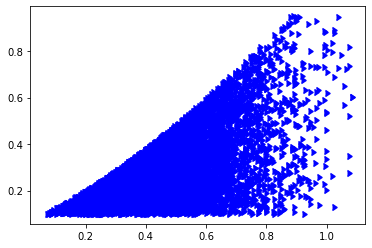

In [41]:
plt.scatter(swings[x_val], swings["roll"], color="blue", label="Swing", marker=CARETRIGHTBASE)
# plt.plot(x, series_s(x),'k')

In [42]:
swings['threshold'].min()

0.06682047026673706

In [43]:
x = np.arange(0.24, 0.8, 0.001)
y_s = np.zeros(x.shape)
y_l = np.zeros(x.shape)
for i, n in enumerate(x):
    y_s[i] = swings[((swings['threshold'] > n) & (swings['threshold'] <= n + 0.01))]['roll'].max()
    y_l[i] = looks[((looks['threshold'] > n) & (looks['threshold'] <= n + 0.01))]['roll'].min()

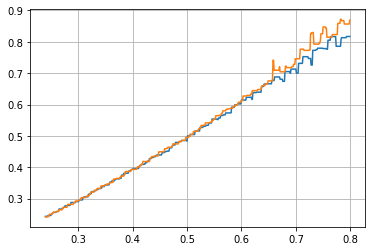

In [44]:
plt.plot(x, y_s)
plt.plot(x, y_l)
plt.grid()

In [45]:
from numpy.polynomial import Polynomial

series_s = Polynomial.fit(x, y_s, 2)
series_l = Polynomial.fit(x, y_l, 2)

In [46]:
print(series_s)
print(series_l)

0.516977282968868 + 0.2996437218285165·x¹ + 0.019685574171296592·x²
0.520052551042309 + 0.31940559375887073·x¹ + 0.040885655777554424·x²


In [47]:
series_s.convert()

Polynomial([0.02804393, 0.81025225, 0.25199067], domain=[-1.,  1.], window=[-1.,  1.])

In [48]:
series_l.convert()

Polynomial([0.06762772, 0.59899536, 0.52336821], domain=[-1.,  1.], window=[-1.,  1.])

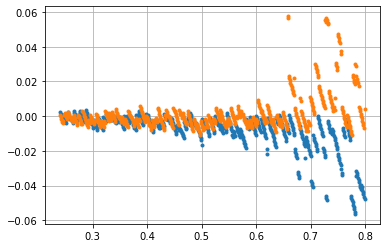

In [209]:
# plt.plot(x, y_s - series_s(x), '.')
# plt.plot(x, y_l - series_l(x), '.')
plt.plot(x, y_s - (0.05 + 0.7*x + 0.4*x**2), '.')
plt.plot(x, y_l - (0.05 + 0.7*x + 0.4*x**2), '.')
plt.grid()

In [50]:
print((series_s.convert().coef + series_l.convert().coef)/2)

[0.04783582 0.70462381 0.38767944]


In [51]:
# let's do *another svc* but polynomial this time
Xpp = dfc[['roll', 'ruth_vibes', 'mox_vibes', 'invpath_scaled', 'ballpark_viscosity']]

scpp = StandardScaler()
Xpp2 = scp.fit_transform(Xpp)

trainedsvm_pp = svm.SVC(kernel='poly', degree=3, max_iter=100000000, C=100000).fit(Xpp2, y)
predictionsvm_pp = trainedsvm_pp.predict(Xpp2)
print(confusion_matrix(y,predictionsvm_pp))
print(classification_report(y,predictionsvm_pp))

[[22327     3]
 [    4  7211]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22330
        True       1.00      1.00      1.00      7215

    accuracy                           1.00     29545
   macro avg       1.00      1.00      1.00     29545
weighted avg       1.00      1.00      1.00     29545



In [199]:
from sklearn.inspection import DecisionBoundaryDisplay

(-4.0, 4.0)

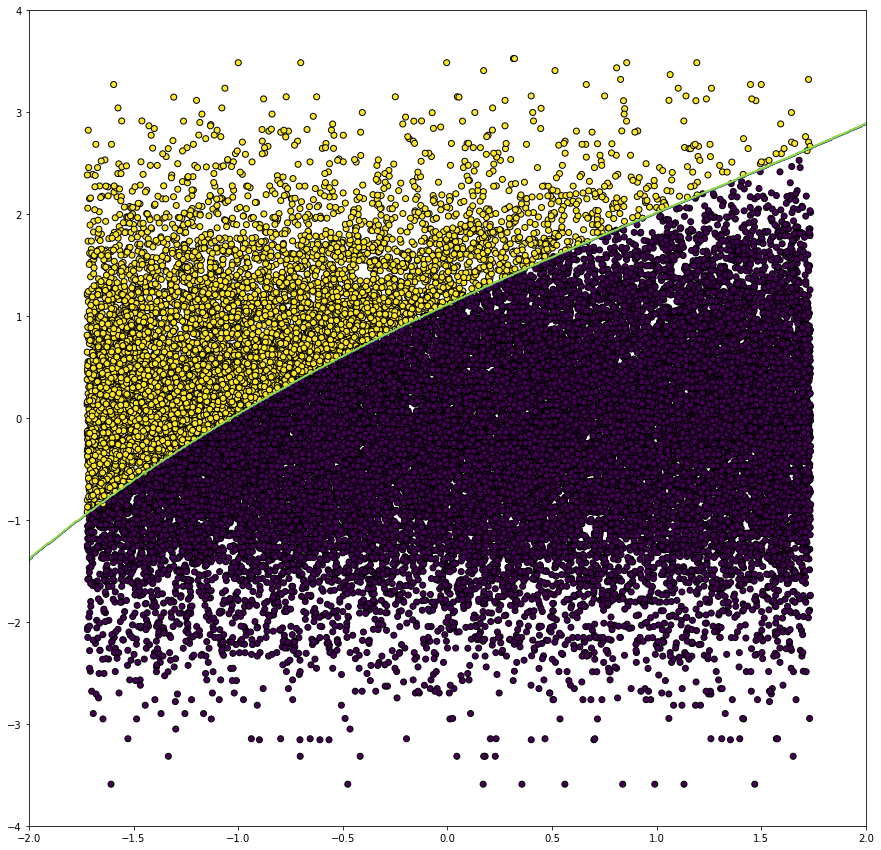

In [202]:
fig, ax = plt.subplots(1, figsize=(15,15))
disp = DecisionBoundaryDisplay.from_estimator(
    trainedsvm_p, Xp2, plot_method = 'contour', ax=ax,
    response_method='predict', grid_resolution=1000)

disp.ax_.scatter(Xp2[:, 0], Xp2[:, 1], c = y, edgecolor="k")
ax.set_xlim(-2, 2)
ax.set_ylim(-4, 4)


In [142]:
plt.scatter?

In [198]:
trainedsvm.get_params()

{'C': 1000,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}